# Timbre transfer



In [22]:
USE_PRIVATE_DISTRO = True

DRIVE_BASE_DIR = '/content/drive/MyDrive/SMC 10/DDSP-10/' 
DRIVE_DISTRO = DRIVE_BASE_DIR + 'dist/ddsp-1.2.0.tar.gz'

if USE_PRIVATE_DISTRO:
    print("[INFO] Using private distro.")
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -qU "$DRIVE_DISTRO"
else:
    !pip install -qU ddsp

import warnings
import gin

import tensorflow as tf

%reload_ext tensorboard
import tensorboard as tb
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from ddsp.colab.colab_utils import specplot
from ddsp.colab.colab_utils import play
from ddsp.training import data
from ddsp.training import models
from ddsp import core

[INFO] Using private distro.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Configuration

In [4]:
SAMPLE_RATE = 48000
DURATION = 4
FRAME_RATE = 250

TIME_STEPS = FRAME_RATE * DURATION
N_SAMPLES = SAMPLE_RATE * DURATION

MOD_FREQ = 50

INSTRUMENT = 'sr{}k_mf{}'.format(SAMPLE_RATE//1000, MOD_FREQ)

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

OUTPUT_FOLDER = 'am_timbre_transfer' #@param {type: "string"}

DRIVE_CHECKPOINTS_DIR = DRIVE_BASE_DIR + 'audio/' + OUTPUT_FOLDER + '/' + \
                         INSTRUMENT + '_checkpoints/'

DRIVE_TFRECORD_PATTERN = DRIVE_BASE_DIR + 'audio/' + OUTPUT_FOLDER + '/' + \
                         INSTRUMENT + '_dataset/train.synthrecord*'

!mkdir -p "$DRIVE_CHECKPOINTS_DIR"

#### Start Tensorboard

In [ ]:
tb.notebook.start('--logdir "{}"'.format(DRIVE_CHECKPOINTS_DIR))

#### Train the model

In [ ]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$DRIVE_CHECKPOINTS_DIR" \
  --gin_file=models/am_simple.gin \
  --gin_file=datasets/synthrecord.gin \
  --gin_param="SynthRecordProvider.file_pattern='$DRIVE_TFRECORD_PATTERN'" \
  --gin_param="SynthRecordProvider.sample_rate=$SAMPLE_RATE" \
  --gin_param="SynthRecordProvider.frame_rate=$FRAME_RATE" \
  --gin_param="SynthRecordProvider.example_secs=$DURATION" \
  --gin_param="F0MIDILoudnessPreprocessor.time_steps=$TIME_STEPS" \
  --gin_param="FilteredNoise.n_samples=$N_SAMPLES" \
  --gin_param="AmplitudeModulation.n_samples=$N_SAMPLES" \
  --gin_param="AmplitudeModulation.sample_rate=$SAMPLE_RATE" \
  --gin_param="train_util.train.batch_size=7" \
  --gin_param="train_util.train.num_steps=20000" \
  --gin_param="train_util.train.steps_per_save=100" \
  --gin_param="train_util.train.steps_per_summary=50" \
  --gin_param="Trainer.checkpoints_to_keep=2" \
  --early_stop_loss_value=5.3 \
  # --gin_param="Trainer.learning_rate=0.0001" \

#### Load pretrained model

In [17]:
data_provider_eval = data.SynthRecordProvider(DRIVE_TFRECORD_PATTERN, 
                                              sample_rate=SAMPLE_RATE,
                                              frame_rate=FRAME_RATE,
                                              example_secs=DURATION)
dataset_eval = data_provider_eval.get_batch(batch_size=1, shuffle=True, repeats=-1)
dataset_eval_iter = iter(dataset_eval)

gin_file = DRIVE_CHECKPOINTS_DIR + 'operative_config-0.gin'
gin.parse_config_file(gin_file)

model = models.Autoencoder()
model.restore(DRIVE_CHECKPOINTS_DIR)

for f in range(12):
  frame = next(dataset_eval_iter)

Original Audio


Full reconstruction


Only am


Only filtered_noise


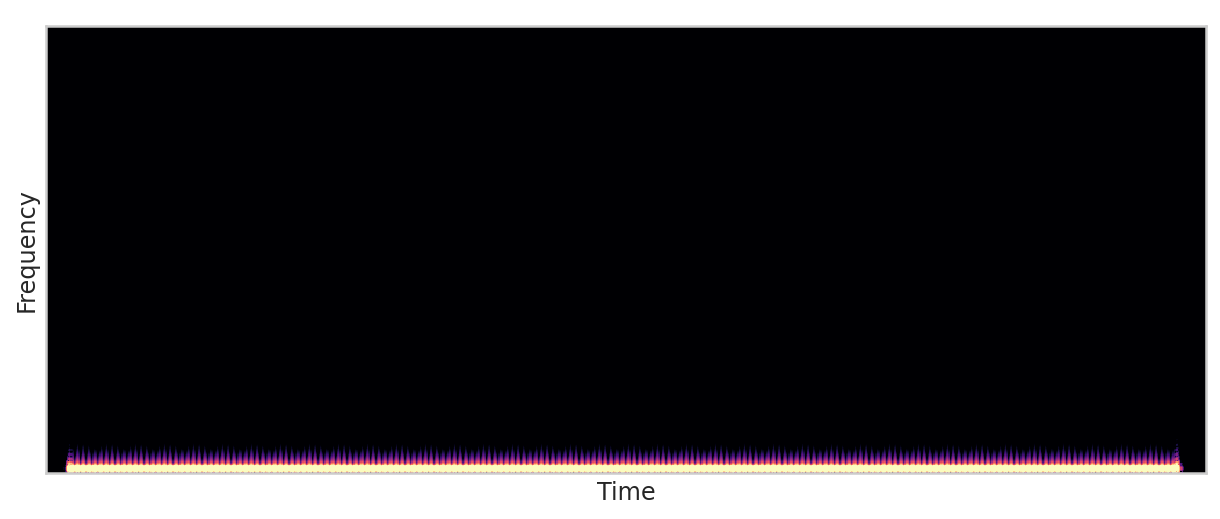

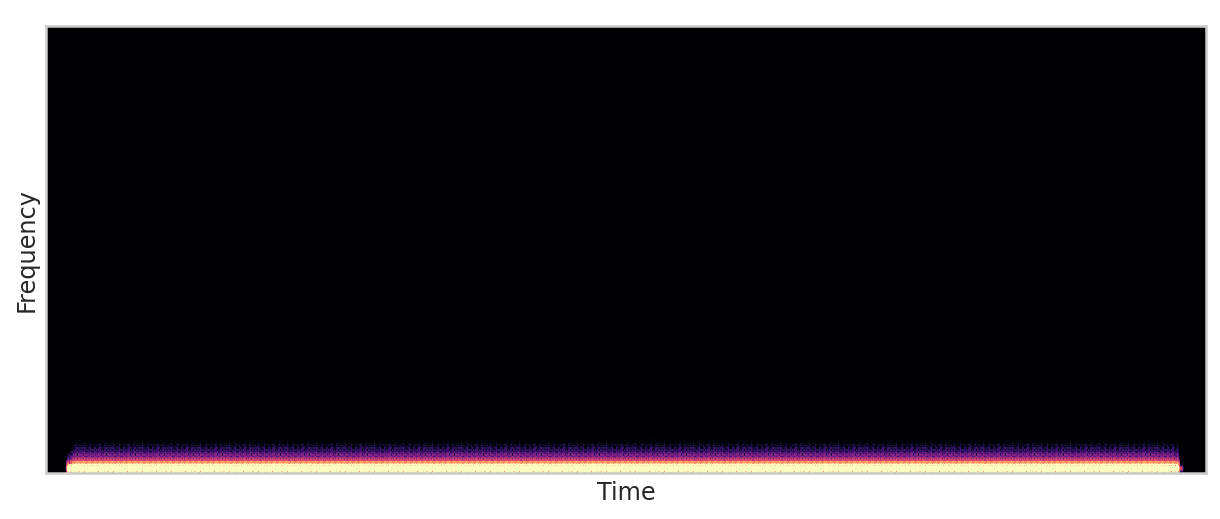

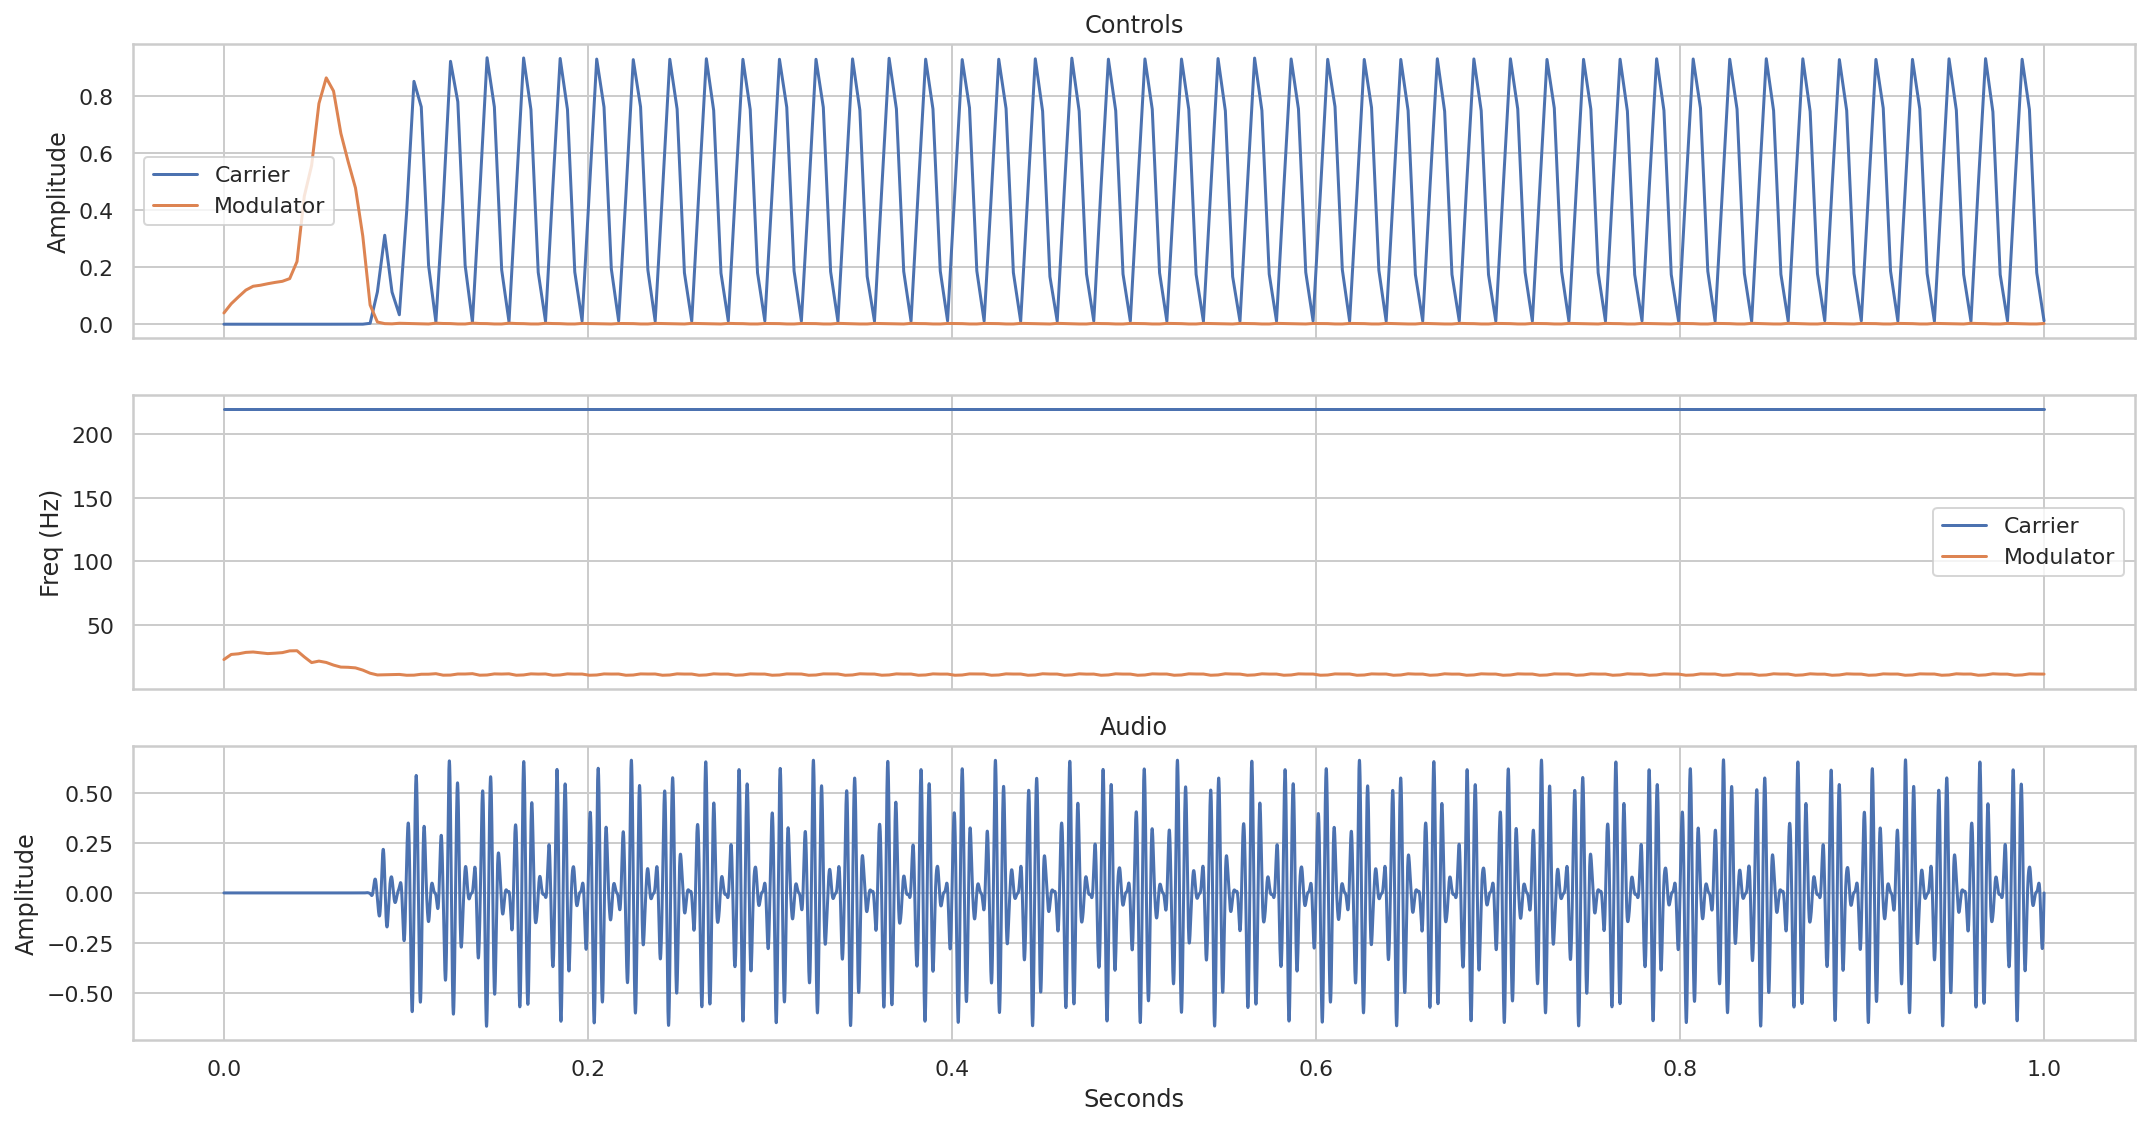

In [56]:
# frame = next(dataset_eval_iter)
audio_baseline = frame['audio']
x = np.linspace(0,1,FRAME_RATE)

controls = model(frame, training=False)
audio_full = model.get_audio_from_outputs(controls)
audio_full /= tf.reduce_max(audio_full[0,:], axis=0).numpy()*1.5

print('Original Audio')
play(audio_baseline, sample_rate=SAMPLE_RATE)

print('Full reconstruction')
play(audio_full, sample_rate=SAMPLE_RATE)

for synth in ['harmonic', 'am', 'filtered_noise']:
  if synth in controls:
    print('Only ' + synth)
    play(controls[synth]['signal'], sample_rate=SAMPLE_RATE)

specplot(audio_baseline)
specplot(audio_full)

get = lambda key: core.nested_lookup(key, controls)[0] #batch 0

amps = get('am/controls/amps')
mod_amps = get('am/controls/mod_amps')

f0 = get('am/controls/f0_hz')
mod_f0 = get('am/controls/mod_f0_hz')

f, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

ax[0].title.set_text('Controls')
# f.suptitle('Inferred controls', fontsize=14)
ax[0].plot(x, amps[:FRAME_RATE], linewidth=1.5)
ax[0].plot(x, mod_amps[:FRAME_RATE], linewidth=1.5)
ax[0].set_ylabel('Amplitude')
ax[0].legend(['Carrier', 'Modulator'])

ax[1].plot(x, f0[:FRAME_RATE], linewidth=1.5)
ax[1].plot(x, mod_f0[:FRAME_RATE], linewidth=1.5)
# ax[1].plot(get('inputs/f0_hz_midi'), linestyle='--')
ax[1].set_ylabel('Freq (Hz)')
ax[1].legend(['Carrier', 'Modulator'])

ax[2].title.set_text('Audio')
ax[2].plot(np.linspace(0,1,SAMPLE_RATE), audio_full.numpy()[0,0:SAMPLE_RATE], linewidth=1.5)
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Seconds')
plt.tight_layout()

In [ ]:
raise SystemExit("Stop right there!")